In [1]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
import tensorflow as tf

from cifar10 import CIFAR10

In [2]:
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.4
tf.set_random_seed(1)
sess = tf.InteractiveSession(config=config)

In [3]:
# Load dataset
batch_size = 64
cifar10 = CIFAR10(batch_size=batch_size, validation_proportion=0.1, augment_data=False, file='nuevos datos/data_original.csv')

SUMMARIES_DIR = './summaries/convnet'

In [4]:
# Model blocks
def conv_layer(input_tensor, kernel_shape, layer_name, stride = 1):
    # input_tensor b01c
    # kernel_shape 01-in-out
    weights = tf.get_variable("weights", kernel_shape,
                               initializer = tf.contrib.layers.xavier_initializer(uniform=False))
    biases = tf.get_variable("biases", [kernel_shape[2]],
                             initializer=tf.constant_initializer(0.05))
    
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    
    # Other options are to use He et. al init. for weights and 0.01 
    # to init. biases.
    conv = tf.nn.conv1d(input_tensor, weights, 
                       stride = stride, padding='SAME')
    return tf.nn.relu(conv + biases)

def fc_layer(input_tensor, weights_shape, layer_name):
    # weights_shape in-out
    weights = tf.get_variable("weights", weights_shape,
                              initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable("biases", [weights_shape[1]],
                             initializer=tf.constant_initializer(0.0))
    tf.summary.histogram(layer_name + "/weights", weights)
    tf.summary.histogram(layer_name + "/biases", biases)
    mult_out = tf.matmul(input_tensor, weights)
    return tf.nn.relu(mult_out+biases)


In [5]:
# Model
model_input = tf.placeholder(tf.float32, name='model_input', 
                             shape=(None,200,1))

keep_prob = tf.placeholder(tf.float32, name='dropout_prob', shape=())

target = tf.placeholder(tf.float32, name='target', shape=(None, 9))

# First convolution layer
layer_name = 'conv1'
with tf.variable_scope(layer_name):
    conv1_out = conv_layer(model_input, [9, 1, 20], layer_name, 2)
# First pooling layer
with tf.name_scope('pool1'):
    pool1_out = tf.nn.pool(conv1_out, window_shape=[2],
                pooling_type="AVG", padding='SAME', strides=[4],
                name='pool1')
    

# Second convolution layer
layer_name = 'conv2'
with tf.variable_scope(layer_name):
    conv2_out = conv_layer(pool1_out, [5, 20, 20], layer_name)
# Second pooling layer
with tf.name_scope('pool2'):
    pool2_out = tf.nn.pool(conv2_out, window_shape=[2],
                pooling_type="AVG", padding='SAME', strides=[1],
                name='pool2')

In [6]:
_,dim3,dim4 = pool2_out.shape
print(dim3,dim4)

25 20


In [7]:
pool2_out_flat = tf.reshape(pool2_out, [-1, 1*dim3.value*dim4.value], name='pool2_flat')
# First fully connected layer
layer_name = 'fc4'
with tf.variable_scope(layer_name):
    fc1_out = fc_layer(pool2_out_flat, [1*dim3.value*dim4.value, 250], layer_name)
fc1_out_drop = tf.nn.dropout(fc1_out, keep_prob)

# Second fully connected layer
layer_name = 'fc5'
with tf.variable_scope(layer_name):
    fc2_out = fc_layer(fc1_out_drop, [250, 100], layer_name)
fc2_out_drop = tf.nn.dropout(fc2_out, keep_prob)


# Third fully connected layer
layer_name = 'fc6'
with tf.variable_scope(layer_name):
    fc3_out = fc_layer(fc2_out_drop, [100,9], layer_name)
model_output = fc3_out


with tf.name_scope('loss_function2'):
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=model_output, labels=target,
                                           name='cross_entropy'))
    tf.summary.scalar('cross_entropy', cross_entropy)

In [8]:
# Optimization
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer()
    grads_vars = optimizer.compute_gradients(cross_entropy)
    optimizer.apply_gradients(grads_vars)
    train_step = optimizer.minimize(cross_entropy)

# Metrics
correct_prediction = tf.equal(tf.argmax(model_output, 1),
                             tf.argmax(target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
tf.summary.scalar('accuracy', accuracy)

# Useful training functions
def validate():
    batches = cifar10.getValidationSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    summary = sess.run(merged,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
    return summary, mean_acc
def test():
    batches = cifar10.getTestSet(asBatches=True)
    accs = []
    for batch in batches:
        data, labels = batch
        acc = sess.run(accuracy,
                       feed_dict={
                model_input: data,
                target: labels,
                keep_prob: 1.0
            })
        accs.append(acc)
    mean_acc = np.array(accs).mean()
    return mean_acc

In [16]:
# Train model
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/trainavg',
                                     sess.graph)
validation_writer = tf.summary.FileWriter(SUMMARIES_DIR+'/validationavg')
#sess.run(tf.global_variables_initializer())
#cifar10.reset()
print("Trainable variables")
for n in tf.trainable_variables():
    print(n.name)

epochs = 2000
mean_gradients = np.zeros([len(tf.trainable_variables()), epochs])
std_gradients = np.zeros([len(tf.trainable_variables()), epochs])

t_i = time.time()
n_batches = cifar10.n_batches
while cifar10.getEpoch() < epochs:
    epoch = cifar10.getEpoch()
    batch, batch_idx = cifar10.nextBatch()
    batch_data = batch[0]
    batch_labels = batch[1]
    
    # just a training iteration
    _ = sess.run(train_step,
                feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 0.5
        })
    
    step = batch_idx+epoch*n_batches
    
    # Write training summary
    if step%50==0:
        summary = sess.run(merged,
                          feed_dict={
                model_input: batch_data,
                target: batch_labels,
                keep_prob: 0.5 # set to 1.0 at inference time
            })
        train_writer.add_summary(summary, step)
        
    # gradient (by layer) statistics over last training batch & validation summary
    if batch_idx==0:
        loss, acc, grads = sess.run((cross_entropy, accuracy, grads_vars), 
                      feed_dict={
            model_input: batch_data,
            target: batch_labels,
            keep_prob: 1.0
        })

        for layer in range(len(tf.trainable_variables())):
            mean_gradients[layer, epoch] = np.mean(np.abs(grads[layer][0]))
            std_gradients[layer, epoch] = np.std(np.abs(grads[layer][0]))
        print("Epoch %d, training loss %f, accuracy %f" % (epoch, loss, acc))
        
        summary, validation_accuracy = validate()
        validation_writer.add_summary(summary, step)
        print("Validation accuracy %f" % validation_accuracy)
        print("Time elapsed", (time.time()-t_i)/60.0, "minutes")
train_writer.flush()
validation_writer.flush()
test_acc = test()
print("Testing set accuracy %f" % test_acc)

Trainable variables
conv1/weights:0
conv1/biases:0
conv2/weights:0
conv2/biases:0
fc4/weights:0
fc4/biases:0
fc5/weights:0
fc5/biases:0
fc6/weights:0
fc6/biases:0
Epoch 1200, training loss 0.461082, accuracy 0.843750
Validation accuracy 0.724375
Time elapsed 0.002430852254231771 minutes
Epoch 1201, training loss 0.631895, accuracy 0.750000
Validation accuracy 0.743750
Time elapsed 0.06184319655100504 minutes
Epoch 1202, training loss 0.725324, accuracy 0.718750
Validation accuracy 0.726875
Time elapsed 0.12970766226450603 minutes
Epoch 1203, training loss 0.627038, accuracy 0.703125
Validation accuracy 0.737500
Time elapsed 0.17969552675882974 minutes
Epoch 1204, training loss 0.607794, accuracy 0.765625
Validation accuracy 0.731250
Time elapsed 0.2412396510442098 minutes
Epoch 1205, training loss 0.682555, accuracy 0.734375
Validation accuracy 0.723750
Time elapsed 0.29551306962966917 minutes
Epoch 1206, training loss 0.507052, accuracy 0.812500
Validation accuracy 0.715000
Time elaps

Epoch 1266, training loss 0.543616, accuracy 0.781250
Validation accuracy 0.738750
Time elapsed 3.879580601056417 minutes
Epoch 1267, training loss 0.538819, accuracy 0.796875
Validation accuracy 0.753750
Time elapsed 3.9320542097091673 minutes
Epoch 1268, training loss 0.682319, accuracy 0.687500
Validation accuracy 0.743750
Time elapsed 3.9854349295298257 minutes
Epoch 1269, training loss 0.448792, accuracy 0.843750
Validation accuracy 0.752500
Time elapsed 4.037633621692658 minutes
Epoch 1270, training loss 0.444351, accuracy 0.828125
Validation accuracy 0.751875
Time elapsed 4.087681686878204 minutes
Epoch 1271, training loss 0.415542, accuracy 0.859375
Validation accuracy 0.748750
Time elapsed 4.137818086147308 minutes
Epoch 1272, training loss 0.698322, accuracy 0.703125
Validation accuracy 0.758750
Time elapsed 4.189967699845632 minutes
Epoch 1273, training loss 0.815866, accuracy 0.703125
Validation accuracy 0.715625
Time elapsed 4.244710969924927 minutes
Epoch 1274, training l

Epoch 1334, training loss 0.685782, accuracy 0.703125
Validation accuracy 0.737500
Time elapsed 7.683741847674052 minutes
Epoch 1335, training loss 0.517610, accuracy 0.781250
Validation accuracy 0.758750
Time elapsed 7.736990952491761 minutes
Epoch 1336, training loss 0.484837, accuracy 0.796875
Validation accuracy 0.750625
Time elapsed 7.787915297349294 minutes
Epoch 1337, training loss 0.599268, accuracy 0.703125
Validation accuracy 0.752500
Time elapsed 7.843719287713369 minutes
Epoch 1338, training loss 0.602028, accuracy 0.796875
Validation accuracy 0.748750
Time elapsed 7.905370422204336 minutes
Epoch 1339, training loss 0.524864, accuracy 0.812500
Validation accuracy 0.750000
Time elapsed 7.963917605082194 minutes
Epoch 1340, training loss 0.576786, accuracy 0.828125
Validation accuracy 0.741250
Time elapsed 8.021491142114003 minutes
Epoch 1341, training loss 0.572862, accuracy 0.812500
Validation accuracy 0.740625
Time elapsed 8.076841127872466 minutes
Epoch 1342, training los

Epoch 1402, training loss 0.643589, accuracy 0.781250
Validation accuracy 0.745625
Time elapsed 11.146793540318807 minutes
Epoch 1403, training loss 0.456371, accuracy 0.781250
Validation accuracy 0.758750
Time elapsed 11.194048941135406 minutes
Epoch 1404, training loss 0.686668, accuracy 0.781250
Validation accuracy 0.750625
Time elapsed 11.241361447175343 minutes
Epoch 1405, training loss 0.475331, accuracy 0.812500
Validation accuracy 0.759375
Time elapsed 11.28768057823181 minutes
Epoch 1406, training loss 0.456743, accuracy 0.890625
Validation accuracy 0.757500
Time elapsed 11.335357979933422 minutes
Epoch 1407, training loss 0.475607, accuracy 0.781250
Validation accuracy 0.760000
Time elapsed 11.385027106602987 minutes
Epoch 1408, training loss 0.511314, accuracy 0.812500
Validation accuracy 0.745000
Time elapsed 11.444195814927419 minutes
Epoch 1409, training loss 0.578772, accuracy 0.734375
Validation accuracy 0.749375
Time elapsed 11.495386906464894 minutes
Epoch 1410, train

Epoch 1469, training loss 0.422933, accuracy 0.875000
Validation accuracy 0.746875
Time elapsed 14.491145237286885 minutes
Epoch 1470, training loss 0.524739, accuracy 0.796875
Validation accuracy 0.763125
Time elapsed 14.545446729660034 minutes
Epoch 1471, training loss 0.530988, accuracy 0.796875
Validation accuracy 0.748750
Time elapsed 14.60259931087494 minutes
Epoch 1472, training loss 0.564919, accuracy 0.750000
Validation accuracy 0.756250
Time elapsed 14.66175430615743 minutes
Epoch 1473, training loss 0.704349, accuracy 0.703125
Validation accuracy 0.727500
Time elapsed 14.71601756811142 minutes
Epoch 1474, training loss 0.540713, accuracy 0.796875
Validation accuracy 0.753125
Time elapsed 14.767553019523621 minutes
Epoch 1475, training loss 0.621957, accuracy 0.703125
Validation accuracy 0.763750
Time elapsed 14.818532148996988 minutes
Epoch 1476, training loss 0.525817, accuracy 0.796875
Validation accuracy 0.755625
Time elapsed 14.869989450772604 minutes
Epoch 1477, trainin

Epoch 1536, training loss 0.543209, accuracy 0.796875
Validation accuracy 0.763125
Time elapsed 17.992776135603588 minutes
Epoch 1537, training loss 0.442535, accuracy 0.843750
Validation accuracy 0.747500
Time elapsed 18.041027116775513 minutes
Epoch 1538, training loss 0.565647, accuracy 0.781250
Validation accuracy 0.759375
Time elapsed 18.08903691371282 minutes
Epoch 1539, training loss 0.487757, accuracy 0.828125
Validation accuracy 0.770625
Time elapsed 18.136354879538217 minutes
Epoch 1540, training loss 0.476827, accuracy 0.843750
Validation accuracy 0.741250
Time elapsed 18.183942262331644 minutes
Epoch 1541, training loss 0.550840, accuracy 0.796875
Validation accuracy 0.763125
Time elapsed 18.23175938129425 minutes
Epoch 1542, training loss 0.553281, accuracy 0.765625
Validation accuracy 0.748750
Time elapsed 18.279296267032624 minutes
Epoch 1543, training loss 0.576482, accuracy 0.812500
Validation accuracy 0.756875
Time elapsed 18.32744468053182 minutes
Epoch 1544, trainin

Epoch 1603, training loss 0.530571, accuracy 0.750000
Validation accuracy 0.756875
Time elapsed 21.259421292940775 minutes
Epoch 1604, training loss 0.489191, accuracy 0.843750
Validation accuracy 0.768750
Time elapsed 21.308299465974173 minutes
Epoch 1605, training loss 0.521529, accuracy 0.781250
Validation accuracy 0.762500
Time elapsed 21.35813093582789 minutes
Epoch 1606, training loss 0.544684, accuracy 0.765625
Validation accuracy 0.763750
Time elapsed 21.410768095652262 minutes
Epoch 1607, training loss 0.475495, accuracy 0.796875
Validation accuracy 0.754375
Time elapsed 21.462184198697408 minutes
Epoch 1608, training loss 0.586158, accuracy 0.765625
Validation accuracy 0.756250
Time elapsed 21.510719100634258 minutes
Epoch 1609, training loss 0.640572, accuracy 0.734375
Validation accuracy 0.757500
Time elapsed 21.55858826637268 minutes
Epoch 1610, training loss 0.442389, accuracy 0.828125
Validation accuracy 0.755000
Time elapsed 21.607284259796142 minutes
Epoch 1611, traini

Epoch 1670, training loss 0.447967, accuracy 0.812500
Validation accuracy 0.768750
Time elapsed 24.520499420166015 minutes
Epoch 1671, training loss 0.727943, accuracy 0.656250
Validation accuracy 0.748125
Time elapsed 24.568670264879863 minutes
Epoch 1672, training loss 0.459782, accuracy 0.812500
Validation accuracy 0.771250
Time elapsed 24.6175199508667 minutes
Epoch 1673, training loss 0.504211, accuracy 0.843750
Validation accuracy 0.753125
Time elapsed 24.66624768177668 minutes
Epoch 1674, training loss 0.357964, accuracy 0.859375
Validation accuracy 0.761250
Time elapsed 24.714710040887198 minutes
Epoch 1675, training loss 0.497994, accuracy 0.781250
Validation accuracy 0.746875
Time elapsed 24.763488765557607 minutes
Epoch 1676, training loss 0.705075, accuracy 0.718750
Validation accuracy 0.759375
Time elapsed 24.81247910261154 minutes
Epoch 1677, training loss 0.587266, accuracy 0.765625
Validation accuracy 0.752500
Time elapsed 24.859680990378063 minutes
Epoch 1678, training

Epoch 1737, training loss 0.429820, accuracy 0.828125
Validation accuracy 0.766875
Time elapsed 27.792495691776274 minutes
Epoch 1738, training loss 0.555013, accuracy 0.718750
Validation accuracy 0.750625
Time elapsed 27.84118834336599 minutes
Epoch 1739, training loss 0.654003, accuracy 0.687500
Validation accuracy 0.759375
Time elapsed 27.890002624193826 minutes
Epoch 1740, training loss 0.602646, accuracy 0.765625
Validation accuracy 0.746250
Time elapsed 27.940118877092996 minutes
Epoch 1741, training loss 0.621495, accuracy 0.718750
Validation accuracy 0.752500
Time elapsed 27.988846429189046 minutes
Epoch 1742, training loss 0.613424, accuracy 0.703125
Validation accuracy 0.761875
Time elapsed 28.03714828491211 minutes
Epoch 1743, training loss 0.439583, accuracy 0.796875
Validation accuracy 0.766250
Time elapsed 28.085556089878082 minutes
Epoch 1744, training loss 0.592835, accuracy 0.781250
Validation accuracy 0.760625
Time elapsed 28.134367589155833 minutes
Epoch 1745, traini

Epoch 1804, training loss 0.430017, accuracy 0.843750
Validation accuracy 0.763125
Time elapsed 31.113100643952688 minutes
Epoch 1805, training loss 0.593148, accuracy 0.734375
Validation accuracy 0.758125
Time elapsed 31.162369108200075 minutes
Epoch 1806, training loss 0.746317, accuracy 0.750000
Validation accuracy 0.703125
Time elapsed 31.210172247886657 minutes
Epoch 1807, training loss 0.464083, accuracy 0.796875
Validation accuracy 0.765000
Time elapsed 31.258322779337565 minutes
Epoch 1808, training loss 0.573560, accuracy 0.765625
Validation accuracy 0.753125
Time elapsed 31.307035410404204 minutes
Epoch 1809, training loss 0.464422, accuracy 0.859375
Validation accuracy 0.754375
Time elapsed 31.355474515755972 minutes
Epoch 1810, training loss 0.381605, accuracy 0.890625
Validation accuracy 0.753750
Time elapsed 31.40588068564733 minutes
Epoch 1811, training loss 0.605695, accuracy 0.718750
Validation accuracy 0.766875
Time elapsed 31.45835030078888 minutes
Epoch 1812, traini

Epoch 1871, training loss 0.551199, accuracy 0.765625
Validation accuracy 0.776875
Time elapsed 34.70696199337642 minutes
Epoch 1872, training loss 0.504882, accuracy 0.796875
Validation accuracy 0.765000
Time elapsed 34.76845311323802 minutes
Epoch 1873, training loss 0.412661, accuracy 0.859375
Validation accuracy 0.759375
Time elapsed 34.83626219828923 minutes
Epoch 1874, training loss 0.345035, accuracy 0.890625
Validation accuracy 0.771250
Time elapsed 34.897167865435286 minutes
Epoch 1875, training loss 0.636030, accuracy 0.734375
Validation accuracy 0.767500
Time elapsed 34.950175221761064 minutes
Epoch 1876, training loss 0.691046, accuracy 0.656250
Validation accuracy 0.773750
Time elapsed 35.01043285131455 minutes
Epoch 1877, training loss 0.594122, accuracy 0.765625
Validation accuracy 0.767500
Time elapsed 35.05905292034149 minutes
Epoch 1878, training loss 0.752618, accuracy 0.718750
Validation accuracy 0.755000
Time elapsed 35.104807968934374 minutes
Epoch 1879, training 

Epoch 1939, training loss 0.570874, accuracy 0.781250
Validation accuracy 0.731250
Time elapsed 38.37215404113134 minutes
Epoch 1940, training loss 0.743400, accuracy 0.703125
Validation accuracy 0.746875
Time elapsed 38.42940081357956 minutes
Epoch 1941, training loss 0.563615, accuracy 0.796875
Validation accuracy 0.753750
Time elapsed 38.48857179880142 minutes
Epoch 1942, training loss 0.373536, accuracy 0.828125
Validation accuracy 0.775000
Time elapsed 38.54399878184001 minutes
Epoch 1943, training loss 0.434319, accuracy 0.859375
Validation accuracy 0.768750
Time elapsed 38.60392245054245 minutes
Epoch 1944, training loss 0.671552, accuracy 0.734375
Validation accuracy 0.758750
Time elapsed 38.66173034509023 minutes
Epoch 1945, training loss 0.648583, accuracy 0.656250
Validation accuracy 0.731250
Time elapsed 38.71501845121384 minutes
Epoch 1946, training loss 0.443097, accuracy 0.812500
Validation accuracy 0.755625
Time elapsed 38.76593673626582 minutes
Epoch 1947, training los

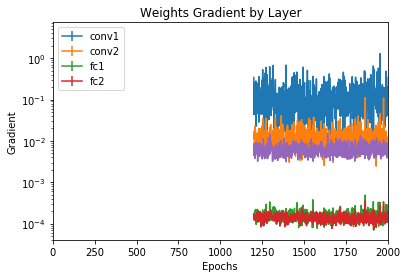

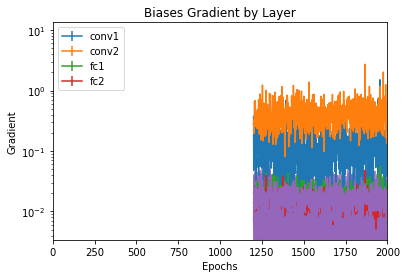

In [17]:
# Plotting gradients
n_layers = len(tf.trainable_variables()) // 2
x = np.arange(epochs)
i = 0
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Weights Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()
i = 1
plt.figure()
while i < n_layers*2:
    plt.errorbar(x,mean_gradients[i,:],std_gradients[i,:])
    i = i + 2
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Epochs')
plt.title('Biases Gradient by Layer')
plt.legend(["conv1","conv2","fc1","fc2"][-n_layers:])
plt.xlim(-0.2, epochs)
plt.show()

In [20]:
def confusion_matrix(targets, outputs):
    '''Returns a confusion matrix. Both targets and outputs
    should be 1-D arrays of zeros and ones.'''
    encoded_data = 2*targets+outputs  # Map targets and outputs to {0, 1, 2, 3}
    TN = np.sum(encoded_data == 0)  # True negatives
    FP = np.sum(encoded_data == 1)  # False positives
    FN = np.sum(encoded_data == 2)  # False negatives
    TP = np.sum(encoded_data == 3)  # True positives
    return ((TP, FP), (FN, TN))

def roc_curve(targets, outputs):
    '''Returns a ROC curve. Outputs should be in range 0-1
    in order to move the threshold.'''
    tpr = []
    fpr = []
    for threshold in np.linspace(0, 1, 1000):
        outputs_with_threshold = (outputs > threshold).astype(np.float)
        ((TP, FP), (FN, TN)) = confusion_matrix(
            targets, 
            outputs_with_threshold)
        tpr.append(TP/(TP+FN))
    fpr.append(FP/(FP+TN))
    return np.array(tpr), np.array(fpr)

accs = sess.run(model_output,
             feed_dict={
            model_input: cifar10.test_data,
                       target: cifar10.test_labels,
            keep_prob: 1.0
        })
matrix = np.zeros([9,9])
print(accs[0]/sum(sum(accs)))
print(np.argmax(cifar10.test_labels[0]))
total = sum(sum(accs))
for i in range(len(accs)):
    matrix[np.argmax(accs[i]),np.argmax(cifar10.test_labels[i])] += 1
    

confusion = tf.confusion_matrix(cifar10.test_labels.reshape(-1),accs.reshape(-1))



[ 0.00033464  0.          0.          0.          0.          0.          0.
  0.          0.        ]
0


In [21]:
print(matrix)
print(sum(matrix))

[[ 169.    0.    1.    1.    0.    3.    0.    0.    3.]
 [   7.  106.    8.    1.   24.   11.    0.    7.   24.]
 [   0.    0.   85.    1.   19.    0.    0.    0.    1.]
 [   0.    1.    1.  191.    5.    0.    0.    0.    3.]
 [   2.    7.   58.    6.  104.    1.    0.    0.    5.]
 [  16.   13.    1.    3.    2.  193.    0.    0.   64.]
 [   0.    0.    4.    0.    1.    0.  182.    0.    0.]
 [   2.    0.   41.    0.   43.    0.    0.  247.    3.]
 [   3.    9.    0.    2.    1.   50.    0.    0.   96.]]
[ 199.  136.  199.  205.  199.  258.  182.  254.  199.]


In [13]:
print(sum(cifar10.test_labels))
print(matrix)

[199 136 199 205 199 258 182 254 199]
[[ 164.    0.    0.    1.    0.    1.    0.    0.    2.]
 [   9.  113.    8.    1.   25.   23.    0.   11.   55.]
 [   0.    0.   75.    1.   19.    0.    0.    0.    1.]
 [   0.    0.    0.  188.    3.    0.    0.    0.    2.]
 [   1.    8.   43.    7.   91.    7.    0.    5.    5.]
 [  20.    7.    2.    3.    3.  172.    0.    0.   53.]
 [   0.    1.    6.    0.    5.    0.  182.    3.    0.]
 [   2.    4.   65.    1.   53.    4.    0.  235.    4.]
 [   3.    3.    0.    3.    0.   51.    0.    0.   77.]]


In [22]:
cifar10.labels

['RRL/RRab',
 'RRL/RRe',
 'EB/ED',
 'CEPH/1O',
 'EB/ESD',
 'RRL/RRd',
 'EB/ED_VAR',
 'EB/ED_ESD',
 'RRL/RRc']